In [5]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

Instrumental efficiency summaries:
---------------------------------

PFS: "We get an RV precision of about 1.5-2.0 m/s on a V = 12 dwarf in 20 minutes"

HARPS-N: "30 minute integrations of Kepler-93 (g=10.4), S/N per pixel of 103, 1 m/s precision" (from Kepler-93 paper)

Keck: fiducial t_exp calculation :"187s for V=8 star for 250k counts" (from exp_time.pro)

Minerva: V=10, 3 m/s in 20m

V of 12-13 typical for K2 candidates

In [6]:
class RVInstrument(object):
    """
    An RV instrument
    
    drv_0, Vmag_0 and texp_0 related as follows:
    
    An observation of duration texp_0 on a Vmag_0 star 
    results in RV precision of drv_0.

    nights = available nights/year for observation 
    """
    def __init__(self, drv_0, Vmag_0, texp_0, drv_floor=1.,
                 nights=3):
        self.drv_0 = drv_0
        self.Vmag_0 = Vmag_0
        self.texp_0 = texp_0
        self.drv_floor = drv_floor
        self.nights = nights
        
    def texp(self, Vmag, drv=2):
        """
        Exposure time required to obtain rv precision of drv for star of Vmag
        
        drv ~ 1/SNR, bottoming out at fundamental limit.
        """
        return self.texp_0 * (self.drv_0/drv)**2 * 10**(0.4*(Vmag - self.Vmag_0))
    


OK, here is my best guess at the fiducial parameters for these various instruments; I print out below how long each instrument takes to reach the desired $\sigma_{RV}$ on a V=12 star... this has HIRES about 2x worse than HARPS, so perhaps I have some of these rough estimates wrong.

In [7]:
PFS = RVInstrument(2, 12, 20, nights=6)
HARPS = RVInstrument(1., 10.4, 30, nights=4)
HIRES = RVInstrument(1.5, 8, 3.1, nights=4)
MINERVA = RVInstrument(3.0, 10.0, 20., nights=300)

print(PFS.texp(12, drv=3))
print(HARPS.texp(12, drv=3))
print(HIRES.texp(12, drv=3))
print(MINERVA.texp(12, drv=3))

8.88888888888889
14.55052774133886
30.853305717896045
126.19146889603867


OK, now define objects required for a survey:

In [8]:
class Star(object):
    def __init__(self, Vmag):
        self.Vmag = Vmag

class Survey(object):
    def __init__(self, targets, instruments):
        self.targets = targets
        self.instruments = instruments
        
    def obs_per_year(self, drv=3):
        """Returns the number of observations in a year for each target
        """
        night = 9 * 60 #in minutes 
        
        nobs = np.zeros(len(self.targets))
        i = 0
        for inst in self.instruments:
            tot_time = night * inst.nights
            while tot_time > 0:
                star = self.targets[i]
                tot_time -= inst.texp(star.Vmag, drv=drv)
                nobs[i] += 1
                i += 1
                if i==len(self.targets):
                    i=0

        return nobs

OK, create a mock survey and see how many times we can observe each star per year:

In [9]:
N = 5
vmags = np.linspace(12, 12.1, N)  #30 targets between V=11 and V=12.5
targets = [Star(vmag) for vmag in vmags]
instruments = [PFS, HARPS, HIRES]
survey = Survey(targets, instruments)

survey.obs_per_year(drv=2.5) 

array([78., 78., 78., 77., 77.])

In [10]:
# Minerva-only survey
N = 200
vmags = np.linspace(9, 11, N)  
targets = [Star(vmag) for vmag in vmags]
instruments = [MINERVA]
survey = Survey(targets, instruments)

survey.obs_per_year(drv=3.) 


array([36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
       36., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
       35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35

In [11]:
def p_of_f(results, prior=np.ones(1000), norm=True):
    nheads = sum(results)
    n = len(results)
    ntails = n-nheads
    f = np.linspace(0,1,len(prior))
    L = f**nheads*(1-f)**ntails
    posterior = L*prior/np.trapz(L*prior,f)
    return f,posterior

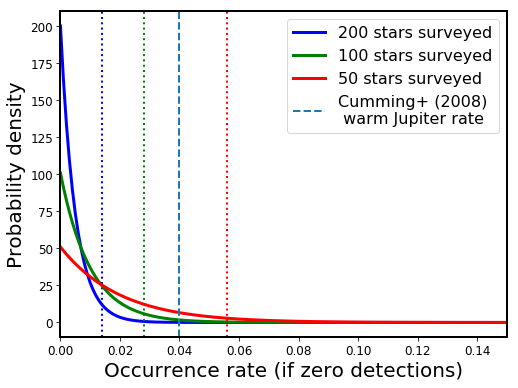

In [15]:
Ns = [200,100,50]
colors = ['b','g','r']

plt.figure(figsize=(8,6))
def find_upperlim(f, post, conf=0.95):
    cum = post.cumsum()
    cdf = cum/cum.max()
    return f[np.argmin(np.absolute(cdf-conf))]
    
for N,color in zip(Ns,colors): 
    f, post = p_of_f(np.zeros(N))
    plt.plot(f,post, label='{} stars surveyed'.format(N), color=color, lw=3)
    plt.axvline(find_upperlim(f,post), color=color, ls=':')
plt.axvline(0.04, ls='--', label='Cumming+ (2008)\n warm Jupiter rate')
plt.xlim(xmax=0.15, xmin=0.)
plt.legend(fontsize=16)
plt.xlabel('Occurrence rate (if zero detections)', fontsize=20)
plt.ylabel('Probability density', fontsize=20);
plt.savefig('occurrence-rate-simple.pdf')